# **영화 리뷰를 사용한 텍스트 분류**

- 리뷰 텍스트를 긍정(positive), 부정(negative)로 분류
- 이진(binary, =클래스(class))이 두개인 분류
- 50,000개의 영화리뷰텍스트, 훈련용 테스트용 각각 25,000개 씩
- 긍정리뷰수 = 부정리뷰수

In [31]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
#매개변수 num_words=10000: 훈련데이터에서 가장 많이 등장하는 상위 10,000개의 단어 선택

## 데이터 탐색

In [32]:
print("훈련샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

#첫번째 리뷰: 
print(train_data[0])  
#리뷰 텍스트는 어휘사전의 특정 단어를 나타내는 정수로 변환되어 있음

#첫번째 리뷰와 두번째 리뷰의 단어 개수 비교:
print(len(train_data[0]), len(train_data[1]))
#신경망의 입력은 길이가 같아야하기 때문에 나중에 이 문제 해결하도록!

훈련샘플: 25000, 레이블: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218 189


### 정수를 단어로 다시 변환하기

In [33]:
#정수와 문자열을 매핑한 딕셔너리 객체에 질의하는 헬퍼함수 만들기:
#단어와 정수 인덱스를 매핑한 딕셔너리 정의하기:
word_index = imdb.get_word_index()

#처음 몇 개 인덱스는 사전에 정의되어 있음. 
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK is an amazing actor and now the same being director <UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK to the two little boy's that played the <UNK of norman and paul they were just brilliant children are often left out of the <UNK list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what the

## 데이터준비

리뷰(정수배열)은 신경망에 주입하기 전에 텐서로 변환되어야 함. 

>변환하는 방법:
1. 원-핫 인코딩(one-hot encoding):
    정수배열을 0과 1로 이루어진 벡터로 변환하고, 
    그 실수 벡터 데이터를 다룰 수 있는 층(dense 층)을 신경망의 첫번째 층으로 사용.
    num_words * num_reviews 크기의 행렬이 필요하기 때문에 메모리 많이 사용.
2. 정수배열의 길이가 모두 같도록 패딩(padding)을 추가, max_length * num_reviews 크기의 정수 텐서 만들기:
    이런 형태의 텐서를 다룰 수 있는 임베딩(embadding)층을 첫번째 층으로 사용. 

In [34]:
#두번째 방법을 사용하여 텐서로 변환하기: 
#영화 리뷰의 길이가 같아야 하므로 pad_sequence함수를 사용해 길이 맞추기:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256
                                                       )
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                       maxlen=256
                                                      )

len(train_data[0]), len(train_data[1])
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 모델 구성하기

신경망은 층(layer)을 쌓아서 만든다. 

이 구조에서 결정해야 할 것: 

    1. 모델에서 얼마나 많은 층을 사용할 것인가?

    2. 각 층에서 얼마나 많은 은닉유닛(hidden unit)을 사용할 것인가?

In [35]:
#입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None, )))
#첫번쨰 층: Embedding 층 
#정수로 인코딩된 단어를 입력받고 각 단어 인덱스에 해당하는 임베딩 벡터 찾기,
#그 벡터는 출력배열에 새로운 차원으로 추가
#최종자원: (batch, sequence, embedding)
model.add(keras.layers.GlobalAveragePooling1D())
#두번째 층:
#sequence차원에 대해 평균계산, 각 샘플에 대해 고정된 길이의 출력 벡터 반환.
#길이가 다른 입력을 다루는 가장 간단한 방법! 
model.add(keras.layers.Dense(16, activation='relu'))
#세번째 층:
#두번째 층까지 거쳐온 '고정길이의 출력벡터' --> 16개의 은닉유닛을 가진 완전연결층(3번째층. Dense층)
model.add(keras.layers.Dense(1, activation='sigmoid'))
#네번째 층: 
#하나의 출력노드를 가진 완전연결층. 
#sigmoid활성화 함수를 이용, 0과1사이의 실수 출력  --> 확률/신뢰도

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### _은닉유닛_
출력의 개수는 층이 가진 표현공간(representational space) 차원.
= 내부표현을 학습할 때 허용되는 네트워크 자유도의 양.

### _손실함수와 옵티마이저_
모델훈련에 필요한 적절한 손실함수와 옵티마이저 고르기: 

1. 손실함수: 

이 예제는 분류문제 & 확률출력 (<-- 출력층의 유닛: 1, & sigmoid 활성화 함수 사용) --> binary_crossentropy 손실함수 사용 

- binary_crossentropy: 확률을 다룰 때 적절한 손실함수. 확률분포간 거리 측정. (타깃(정답) 분포와 예측 분포의 거리 측정)
- mean squared error: 회귀문제(regression). 가격예측 등에 적절한 손실함수. 

2. 옵티마이저:


In [36]:
#모델이 사용할 옵티마이저와 손실함수 설정하기:
model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

### 검증세트 만들기

모델을 훈련할 때: 모델이 만난 적 없는 데이터에서 정확도 확인하도록 

In [37]:
#원본 훈련 데이터에서 10.000개의 샘플을 떼어네어 검증세트(validation set)로 만들기:
#훈련데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표.
#테스트세트는 정확도 평가시 딱 한번만 사용.

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val =  train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련하기

In [38]:
#이 모델을 512개의 샘플로 이루어진 미니배치(mini-batch)에서 
#40번의 epoch동안 훈련.
#=x_train과 y_train텐서에 있는 모든 샘플에 대해 40번 반복.
#훈련하는동안 10,000개의 검증세트에서 모델의 손실과 정확도 모니터링.
history = model.fit(partial_x_train,
                   partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1
                   )

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 87us/sample - loss: 0.6922 - accuracy: 0.5160 - val_loss: 0.6908 - val_accuracy: 0.6567
Epoch 2/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.6874 - accuracy: 0.6946 - val_loss: 0.6837 - val_accuracy: 0.6925
Epoch 3/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6759 - accuracy: 0.7345 - val_loss: 0.6685 - val_accuracy: 0.7494
Epoch 4/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6543 - accuracy: 0.7649 - val_loss: 0.6428 - val_accuracy: 0.7626
Epoch 5/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.6205 - accuracy: 0.7883 - val_loss: 0.6068 - val_accuracy: 0.7796
Epoch 6/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.5763 - accuracy: 0.8096 - val_loss: 0.5637 - val_accuracy: 0.8006
Epoch 7/40
15000/15000 [==============================] 

### 모델 평가하기

In [39]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/25000 - 1s - loss: 0.3359 - accuracy: 0.8711
[0.33594506986618045, 0.87112]


### 정확도와 손실그래프 그리기 

In [42]:
#model.fit()은 History 객체 반환. 
#훈련하는동안 일어난 모든 정보가 담긴 딕셔너리가 들어있다. 
history_dict = history.history
history_dict.keys()    
#loss, accuracy, val_loss, val_accuracy --훈련과 검증단계에서 모니터링하는 지표들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

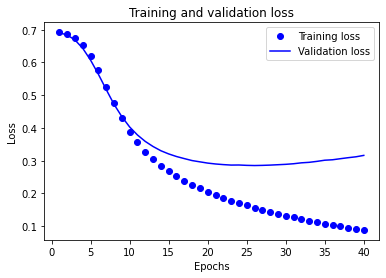

In [45]:
#훈련손실과 검증손실 그래프로 그리기
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

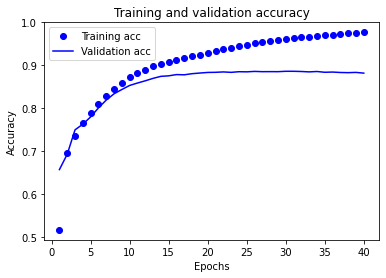

In [47]:
#훈련정확도와 검증정확도 그래프로 그리기 
plt.clf()    #그림초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### _그래프분석_

훈련손실: 에포크마다 감소
훈련정확도: 에포크마다 증가 
--> 경사하강법 최적화를 사용할 때 볼 수 있는 현상!
    경사하강법은 매 반복마다 최적화 대상의 값을 최소화!
    
but 검승손실/검증정확도에서는 그렇지 않음. --∵과대적합
remember, 이전에 본 적 없는 데이터보다 훈련된 데이터에서 더 잘 동작한다.
과대적합 시점부터는 모델이 과도하게 최적화되어 
테스트데이터에서 일반화되기 어려운 훈련데이터의 특정표현을 학습한다. 

과대적합을 막기 위해:
(단순하게) 그래프에서 과대적합시점으로 보이는 에포크 근처에서 훈련 멈추기. 
--callback 사용
